<a href="https://www.kaggle.com/code/didemparlak/level-based-customer-segmentation?scriptVersionId=120364295" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Level Based Customer Segmentation**



The dataset belongs to an international game company. The data includes the amount customers spend in the game and demographic features such as the age and country of the customers.

> <div class="alert alert-block alert-danger">
<b></b> The game company wants to segment its customers with the data it has and to estimate how much the new customer will spend.
</div>

The data set consists of records created in each sales transaction. The case of a user making more than one purchase should be considered. The data is not deduplicated.

   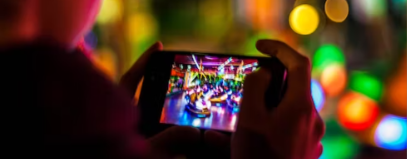

**Variables**
* **PRICE** : Price of the game
* **SOURCE** : Platform of the game was downloaded
* **SEX** : Gender of the user
* **COUNTRY** : Country where the user downloaded the game
* **AGE** : Age of the user

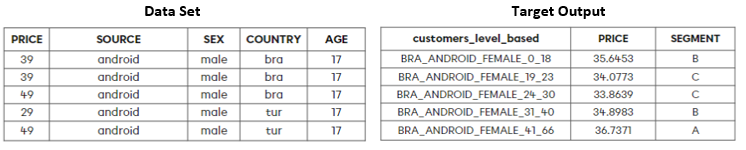

In [1]:
import pandas as pd
pd.set_option("display.max_rows", 50)
df = pd.read_csv("../input/persona/persona.csv")

I chose to define a function(check_df) to look at the data. After the changes made, the function can be run again practically to see how the change affects the data.

In [2]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [3]:
check_df(df)

##################### Shape #####################
(5000, 5)
##################### Types #####################
PRICE       int64
SOURCE     object
SEX        object
COUNTRY    object
AGE         int64
dtype: object
##################### Head #####################
   PRICE   SOURCE   SEX COUNTRY  AGE
0     39  android  male     bra   17
1     39  android  male     bra   17
2     49  android  male     bra   17
3     29  android  male     tur   17
4     49  android  male     tur   17
##################### Tail #####################
      PRICE   SOURCE     SEX COUNTRY  AGE
4995     29  android  female     bra   31
4996     29  android  female     bra   31
4997     29  android  female     bra   31
4998     39  android  female     bra   31
4999     29  android  female     bra   31
##################### NA #####################
PRICE      0
SOURCE     0
SEX        0
COUNTRY    0
AGE        0
dtype: int64
##################### Quantiles #####################
        count     mean        std  

In [4]:
#About 'source'- counts of unique values
print(df["SOURCE"].value_counts())

android    2974
ios        2026
Name: SOURCE, dtype: int64


In [5]:
#Percentage distribution of the 'source'
100*df["SOURCE"].value_counts()/len(df)

android    59.48
ios        40.52
Name: SOURCE, dtype: float64

In [6]:
# How many sales were made at which PRICE?
print(df["PRICE"].nunique())
df["PRICE"].value_counts()

6


29    1305
39    1260
49    1031
19     992
59     212
9      200
Name: PRICE, dtype: int64

In [7]:
#Percentage distribution of the price variable
100*df["PRICE"].value_counts()/len(df)

29    26.10
39    25.20
49    20.62
19    19.84
59     4.24
9      4.00
Name: PRICE, dtype: float64

In [8]:
#How many sales were made from which country?
df["COUNTRY"].value_counts()

usa    2065
bra    1496
deu     455
tur     451
fra     303
can     230
Name: COUNTRY, dtype: int64

In [9]:
#How much was earned in total from sales by country?
#df.groupby("COUNTRY")["PRICE"].sum()
df.pivot_table(values="PRICE",index="COUNTRY",aggfunc="sum")

,PRICE
COUNTRY,
bra,51354
can,7730
deu,15485
fra,10177
tur,15689
usa,70225


In [10]:
#What are the price averages by country?
df.groupby("COUNTRY").agg({"PRICE":"mean"})

,PRICE
COUNTRY,
bra,34.327540
can,33.608696
deu,34.032967
fra,33.587459
tur,34.787140
usa,34.007264


In [11]:
#Average earnings in breakdown of COUNTRY, SOURCE, SEX, AGE
agg_df = df.groupby(["COUNTRY", 'SOURCE', "SEX", "AGE"]).agg({"PRICE": "mean"}).sort_values(by="PRICE", ascending=False)
agg_df.head()

,,,,PRICE
COUNTRY,SOURCE,SEX,AGE,
bra,android,male,46,59.0
usa,android,male,36,59.0
fra,android,female,24,59.0
usa,ios,male,32,54.0
deu,android,female,36,49.0


In [12]:
#All variables are in the index except 'price' in agg_df. 
agg_df.reset_index(inplace=True)
agg_df.head()

,COUNTRY,SOURCE,SEX,AGE,PRICE
0,bra,android,male,46,59.0
1,usa,android,male,36,59.0
2,fra,android,female,24,59.0
3,usa,ios,male,32,54.0
4,deu,android,female,36,49.0


In [13]:
#The age variable is divided into categories and added to agg_df.
bins = [0, 18, 23, 30, 40, agg_df["AGE"].max()]
mylabels = ['0_18', '19_23', '24_30', '31_40', '41_' + str(agg_df["AGE"].max())]
agg_df["AGE_CAT"] = pd.cut(agg_df["AGE"], bins, labels=mylabels)
agg_df.head()

,COUNTRY,SOURCE,SEX,AGE,PRICE,AGE_CAT
0,bra,android,male,46,59.0,41_66
1,usa,android,male,36,59.0,31_40
2,fra,android,female,24,59.0,24_30
3,usa,ios,male,32,54.0,31_40
4,deu,android,female,36,49.0,31_40


<AxesSubplot:xlabel='AGE_CAT', ylabel='PRICE'>

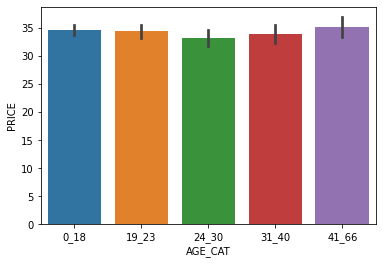

In [14]:
import seaborn as sns
sns.barplot(x="AGE_CAT", y="PRICE", data=agg_df)

**Creating Customer Segments**

In [15]:
#Defining new level-based customers (personas) and adding them as variables to the dataset
agg_df["customers_level_based"] = ['_'.join(i).upper() for i in agg_df[['COUNTRY', 'SOURCE', 'SEX', 'AGE_CAT']].values]
agg_df.head()

,COUNTRY,SOURCE,SEX,AGE,PRICE,AGE_CAT,customers_level_based
0,bra,android,male,46,59.0,41_66,BRA_ANDROID_MALE_41_66
1,usa,android,male,36,59.0,31_40,USA_ANDROID_MALE_31_40
2,fra,android,female,24,59.0,24_30,FRA_ANDROID_FEMALE_24_30
3,usa,ios,male,32,54.0,31_40,USA_IOS_MALE_31_40
4,deu,android,female,36,49.0,31_40,DEU_ANDROID_FEMALE_31_40


In [16]:
agg_df["customers_level_based"].value_counts()

BRA_ANDROID_MALE_24_30      7
USA_ANDROID_MALE_41_66      7
USA_IOS_FEMALE_24_30        7
BRA_ANDROID_FEMALE_24_30    7
USA_ANDROID_MALE_24_30      7
                           ..
TUR_ANDROID_MALE_41_66      1
CAN_ANDROID_MALE_19_23      1
TUR_IOS_MALE_31_40          1
TUR_IOS_MALE_24_30          1
CAN_ANDROID_FEMALE_24_30    1
Name: customers_level_based, Length: 109, dtype: int64

In [17]:
#Singularization according to segments due to more than one of the same segment
agg_df = agg_df.groupby("customers_level_based").agg({"PRICE": "mean"})
agg_df.head()

,PRICE
customers_level_based,
BRA_ANDROID_FEMALE_0_18,35.645303
BRA_ANDROID_FEMALE_19_23,34.077340
BRA_ANDROID_FEMALE_24_30,33.863946
BRA_ANDROID_FEMALE_31_40,34.898326
BRA_ANDROID_FEMALE_41_66,36.737179


In [18]:
agg_df = agg_df.reset_index()
agg_df.head()

,customers_level_based,PRICE
0,BRA_ANDROID_FEMALE_0_18,35.645303
1,BRA_ANDROID_FEMALE_19_23,34.077340
2,BRA_ANDROID_FEMALE_24_30,33.863946
3,BRA_ANDROID_FEMALE_31_40,34.898326
4,BRA_ANDROID_FEMALE_41_66,36.737179


In [19]:
#Segment new customers (personas)
#Dividing new customers into 4 segments according to price
agg_df["SEGMENT"] = pd.qcut(agg_df["PRICE"], 4, labels=["D", "C", "B", "A"])
agg_df.head()

,customers_level_based,PRICE,SEGMENT
0,BRA_ANDROID_FEMALE_0_18,35.645303,B
1,BRA_ANDROID_FEMALE_19_23,34.077340,C
2,BRA_ANDROID_FEMALE_24_30,33.863946,C
3,BRA_ANDROID_FEMALE_31_40,34.898326,B
4,BRA_ANDROID_FEMALE_41_66,36.737179,A


In [20]:
#Classification of new customers and estimation of how much revenue they can generate
new_user = "TUR_ANDROID_FEMALE_31_40"
agg_df[agg_df["customers_level_based"] == new_user]

,customers_level_based,PRICE,SEGMENT
72,TUR_ANDROID_FEMALE_31_40,41.833333,A


A 33-year-old Turkish woman using android belongs to segment A and estimating the average price is 41.8

In [21]:
new_user = "FRA_IOS_FEMALE_31_40"
agg_df[agg_df["customers_level_based"] == new_user]

,customers_level_based,PRICE,SEGMENT
63,FRA_IOS_FEMALE_31_40,32.818182,C


A 35-year-old French woman using IOS belongs to segment C and estimating the average price is 32.8